# Proyecto Final 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import pandas as pd
from sklearn import svm
from math import sqrt, pi, exp 

sns.set(style="darkgrid")
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()



Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Carga de datos
all_data = pd.read_csv('data_titanic_proyecto.csv')
# Cada vez que se vuelvan a cargar los datos, necesitaremos volver a transformar
transformed_categoric = False

## Análisis exploratorio y limpieza de datos

Buscaremos valores faltantes en todo el dataset para saber si se espera tener que realizar imputación. 

In [4]:
all_data.isna().sum()

PassengerId             0
Name                    0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

Vemos que Cabin tiene muchos valores faltantes, por lo que sería difícil realizar imputación, pero podemos utilizar estadística descriptiva para rellenar los valores faltantes en Age y Embarked.

Veamos una muestra del data set para familiarizarnos con las variables

In [5]:
all_data.sample(4)

PassengerId                                       Name   Age  SibSp  \
781          782  Dick, Mrs. Albert Adrian (Vera Gillespie)  17.0      1   
196          197                        Mernagh, Mr. Robert   NaN      0   
868          869                van Melkebeke, Mr. Philemon   NaN      0   
632          633                  Stahelin-Maeglin, Dr. Max  32.0      0   

     Parch  Ticket   Fare Cabin Embarked passenger_class passenger_sex  \
781      0   17474  57.00   B20        S           Upper             F   
196      0  368703   7.75   NaN        Q           Lower             M   
868      0  345777   9.50   NaN        S           Lower             M   
632      0   13214  30.50   B50        C           Upper             M   

    passenger_survived  
781                  Y  
196                  N  
868                  N  
632                  Y

SibSp es la suma del número de hermanos y cónyugues a bordo para el pasajero. 

Parch es la cantidad de padres e hijos a bordo. 

Embarked es la inicial del puerto donde embarcaró el pasajero. 



### Transformación de variables categóricas
Vemos que la clase del pasajero es categórica (Upper, Lower, Middle) pero nos interesa su correlación con otras variables, por lo que la cambiaremos a una categórica numérica. Lo mismo con la variable objetivo, passenger_survived y passenger_sex.

In [7]:
if not transformed_categoric:
    all_data["passenger_class"] = all_data["passenger_class"].replace({"Upper" : 1, "Middle" : 2, "Lower" : 3}).astype('int32')
    all_data["passenger_survived"] = all_data["passenger_survived"].replace({"Y" : 1, "N" : 0}).astype('int32')
    all_data["passenger_sex"] = all_data["passenger_sex"].replace({"M" : 1, "F" : 0}).astype('int32')
    all_data["Embarked"] = all_data["Embarked"].replace({"Q" : 0, "C" : 1, "S": 2})
    transformed_categoric = True

Ahora que hemos transformado esas variables en todo el data set, podemos separarlo en los sets de entrenamiento, validación y prueba. También podremos analizar la correlación gracias a las variables que convertimos a numéricas y ver sus estadísticas descriptivas.

In [25]:
all_data.describe().drop('count').drop('PassengerId', axis=1)

Age     SibSp     Parch        Fare  Embarked  passenger_class  \
mean  29.197722  0.523008  0.381594   32.204208  1.638608         2.308642   
std   13.236389  1.102743  0.806057   49.693429  0.635673         0.836071   
min    0.420000  0.000000  0.000000    0.000000  0.000000         1.000000   
25%   22.000000  0.000000  0.000000    7.910400  1.000000         2.000000   
50%   26.000000  0.000000  0.000000   14.454200  2.000000         3.000000   
75%   36.000000  1.000000  0.000000   31.000000  2.000000         3.000000   
max   80.000000  8.000000  6.000000  512.329200  2.000000         3.000000   

      passenger_sex  passenger_survived  
mean       0.647587            0.383838  
std        0.477990            0.486592  
min        0.000000            0.000000  
25%        0.000000            0.000000  
50%        1.000000            0.000000  
75%        1.000000            1.000000  
max        1.000000            1.000000

In [8]:
train_set = test_set = validation_set = None
def split_dataset():
    global train_set, test_set, validation_set
    train_set, test_set = train_test_split(all_data, test_size=0.2, random_state=420*666)
    train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=420*666)
    return train_set, validation_set, test_set

split_dataset()

print("all_data shape", all_data.shape)
print("train_set shape", train_set.shape)
print("validation_set shape", validation_set.shape)


all_data shape (891, 12)
train_set shape (569, 12)
validation_set shape (143, 12)


In [9]:
train_set.corr().abs()

PassengerId       Age     SibSp     Parch      Fare  \
PassengerId            1.000000  0.069606  0.038611  0.022055  0.014407   
Age                    0.069606  1.000000  0.277610  0.162013  0.072028   
SibSp                  0.038611  0.277610  1.000000  0.412171  0.183415   
Parch                  0.022055  0.162013  0.412171  1.000000  0.190890   
Fare                   0.014407  0.072028  0.183415  0.190890  1.000000   
Embarked               0.049909  0.012376  0.083905  0.097895  0.100815   
passenger_class        0.030610  0.306439  0.050290  0.038240  0.566640   
passenger_sex          0.069002  0.091986  0.138134  0.259041  0.234383   
passenger_survived     0.027587  0.087042  0.033621  0.047219  0.299864   

                    Embarked  passenger_class  passenger_sex  \
PassengerId         0.049909         0.030610       0.069002   
Age                 0.012376         0.306439       0.091986   
SibSp               0.083905         0.050290       0.138134   
Parch               0.097895         0.038240       0.259041   
Fare                0.100815         0.566640       0.234383   
Embarked            1.000000         0.006342       0.129316   
passenger_class     0.006342         1.000000       0.156165   
passenger_sex       0.129316         0.156165       1.000000   
passenger_survived  0.146525         0.365862       0.533318   

                    passenger_survived  
PassengerId                   0.027587  
Age                           0.087042  
SibSp                         0.033621  
Parch                         0.047219  
Fare                          0.299864  
Embarked                      0.146525  
passenger_class               0.365862  
passenger_sex                 0.533318  
passenger_survived            1.000000

### Imputación de vaalores faltantes

Observamos que Age tiene la mayor correlación con passenger_class, por lo que agruparemos para calcular la mediana de edad por clase. Otro dato interesante sería la mediana de edad por sexo.

In [10]:
print("Medianas")
print(train_set.groupby('passenger_class').median()['Age'], "\n")
print(train_set.groupby('passenger_sex').median()['Age'], "\n")

print("\nMedias")
print(train_set.groupby('passenger_class').mean()['Age'], "\n")
print(train_set.groupby('passenger_sex').mean()['Age'], "\n")

Medianas
passenger_class
1    36.0
2    30.0
3    25.0
Name: Age, dtype: float64 

passenger_sex
0    27.0
1    29.0
Name: Age, dtype: float64 


Medias
passenger_class
1    36.503590
2    29.708276
3    26.054330
Name: Age, dtype: float64 

passenger_sex
0    28.021802
1    30.643860
Name: Age, dtype: float64 



Vemos un aumento significativo en la mediana de la edad conforme la clase aumenta. También vemos que las mujeres son ligeramente más jóvenes. Ahora veamos cómo se comportan las edades al agrupar por ambos.

In [11]:
median_ages_by_class_and_sex = train_set.groupby(['passenger_class', 'passenger_sex']).median()['Age']
median_ages_by_class_and_sex


passenger_class  passenger_sex
1                0                33.0
                 1                39.0
2                0                28.0
                 1                30.0
3                0                22.0
                 1                26.0
Name: Age, dtype: float64

Con estos datos podemos rellenar la edad de los faltantes de cada grupo.

In [12]:
for pclass in range(1,4):
    for sex in range(0,2):
        condition = (all_data['passenger_class'] == pclass) & (all_data['passenger_sex'] == sex)
        all_data['Age'][condition] = all_data['Age'][condition].fillna(median_ages_by_class_and_sex[pclass][sex])

all_data['Age'].isna().sum()

0

Usaremos la moda de Embarked para rellenar los dos faltanes

In [13]:
all_data['Embarked'] = all_data['Embarked'].fillna(test_set['Embarked'].mode()[0]).astype('int32')
all_data['Embarked'].isna().sum()

0

In [14]:

split_dataset() # actualizamos nuestros subsets con los faltantes rellenados

print(test_set['Age'].isna().sum())
print(test_set['Embarked'].isna().sum())
print(validation_set['Age'].isna().sum())
print(validation_set['Embarked'].isna().sum())
print(train_set['Age'].isna().sum())
print(train_set['Embarked'].isna().sum())

0
0
0
0
0
0


### Correlación entre variables

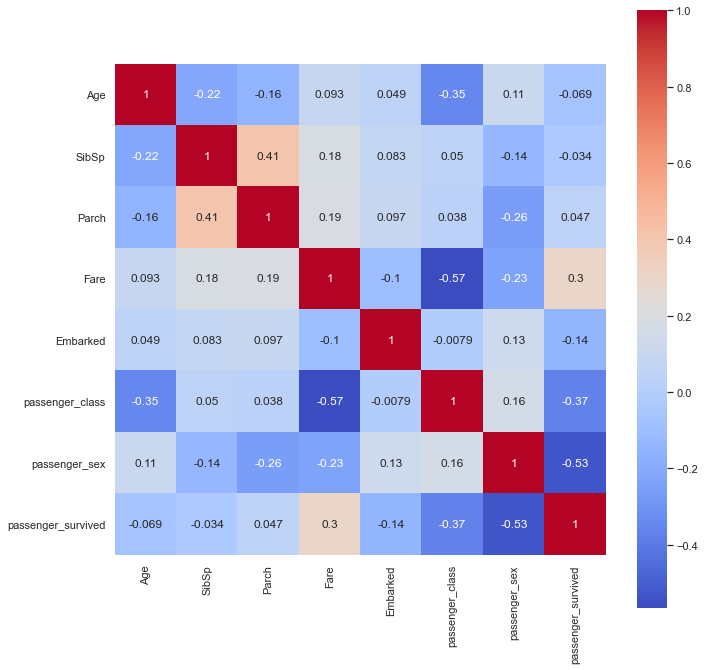

In [15]:
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(train_set.drop('PassengerId', axis=1).corr(), cmap='coolwarm', annot=True, ax=ax, square=True)

Vemos que variables como la clase, el sexo, la tarifa y el puerto de embarcación tienen una correlación relativamente alta con la variable objetivo.

### Análisis visual
Intentaremos explorar los datos por medio de gráficas que puedan ser relevantes y brindar nueva información.

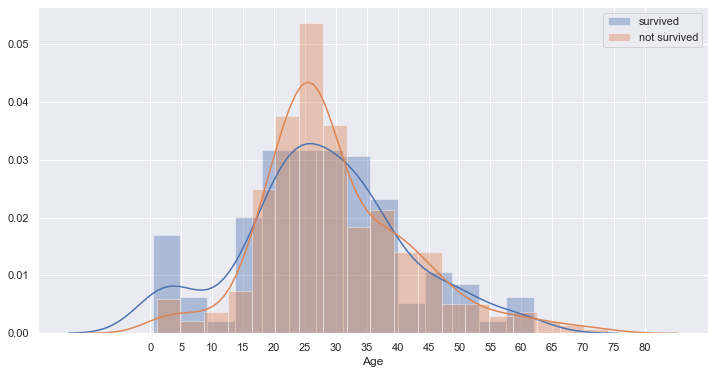

In [33]:
plt.figure(figsize=(12,6))
survived = train_set['passenger_survived'] == 1
sns.distplot(train_set[survived]["Age"],  label="survived")
sns.distplot(train_set[~survived]["Age"],  label="not survived")
plt.gca().set_xticks(range(0, 85, 5))


sns.distplot
plt.legend()
plt.show()

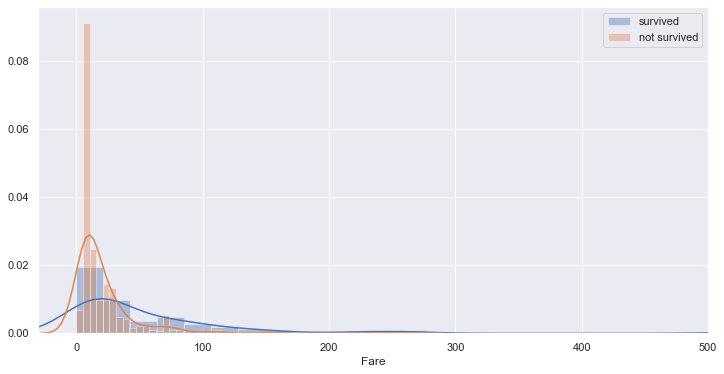

In [31]:
plt.figure(figsize=(12,6))
survived = train_set['passenger_survived'] == 1
sns.distplot(train_set[survived]["Fare"],  label="survived")
sns.distplot(train_set[~survived]["Fare"],  label="not survived")
plt.gca().set_xlim(-30, 500)
sns.distplot
plt.legend()
plt.show()

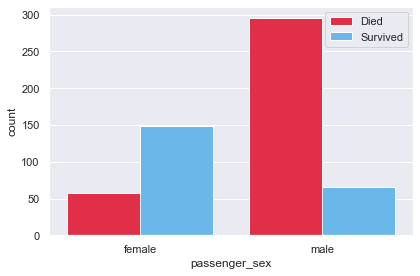

In [67]:


ax = sns.countplot(x='passenger_sex', data=train_set, hue='passenger_survived', palette=['#f13', '#5bf'])
ax.set_xticklabels(['female', 'male'])
plt.legend(['Died',  'Survived'])

plt.tight_layout()
plt.show()

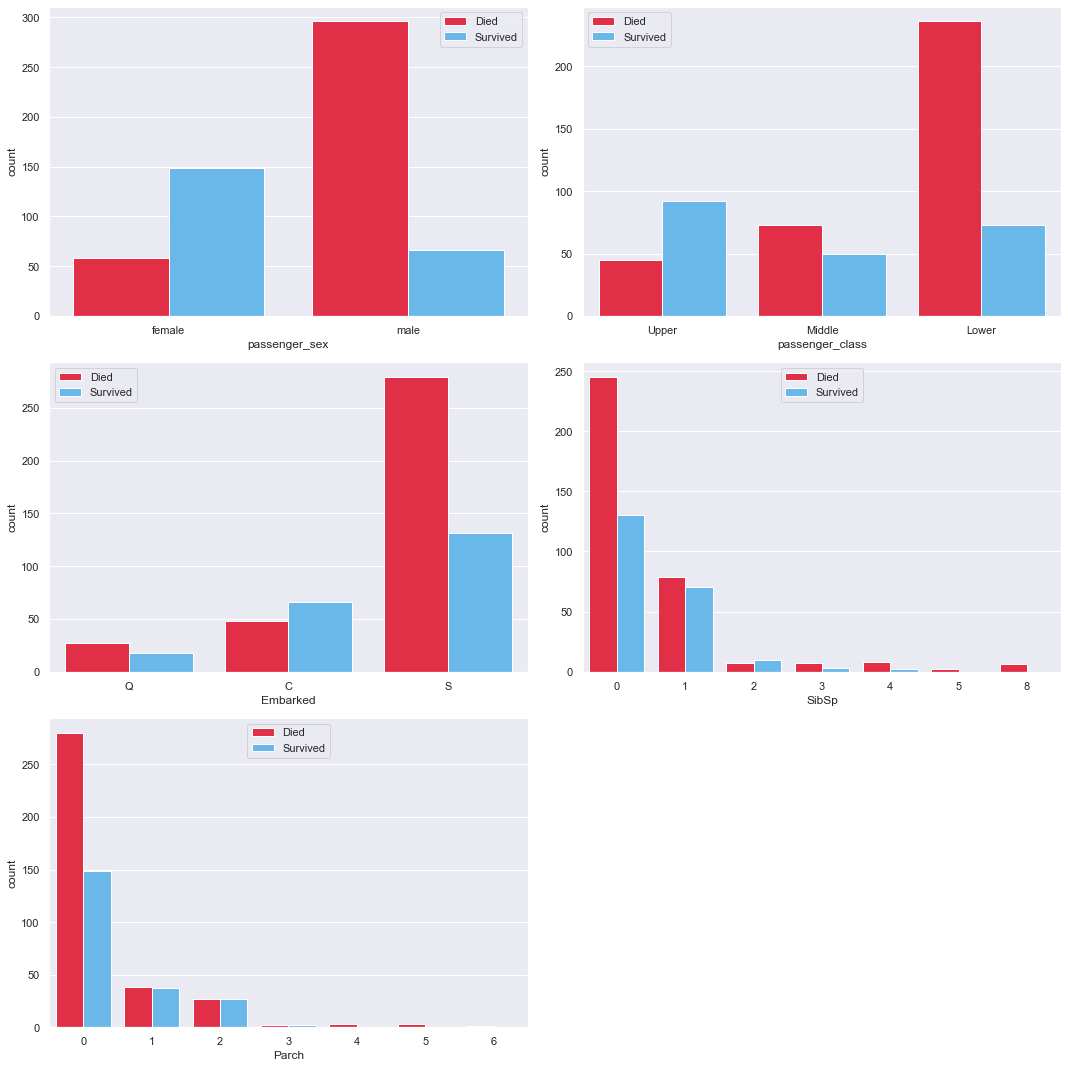

In [83]:
features = ['passenger_sex', 'passenger_class', 'Embarked', 'SibSp', 'Parch']
xticks = {'passenger_sex' : ['female', 'male'], 'passenger_class' : ['Upper', 'Middle', 'Lower'], 'Embarked' : ['Q', 'C', 'S']}

for i, feat in enumerate(features, 1):
    ax = plt.subplot(3,2,i)
    ax.get_figure().set_size_inches(15,15)
    cax = sns.countplot(x=feat, data=train_set, hue='passenger_survived', palette=['#f13', '#5bf'])
    plt.legend(['Died',  'Survived'])
    ticks = xticks.get(feat)
    if ticks:
        cax.set_xticklabels(ticks)

plt.tight_layout()
plt.show()

## Modelos de predicción individuales

### Clasificador Naive Bayes

In [25]:
class NaiveBayes:
    def __init__(self, train_x, train_y, x_labels=None):
        self.x_labels = x_labels
        df = self.__init_dataframe(train_x, train_y)
        by_class = df.groupby('y')
        self.means = by_class.mean()
        self.stdvs = by_class.std()
        self.cdist = by_class['y'].count() / df.shape[0]

    def __init_dataframe(self, train_x, train_y):
        df = pd.DataFrame()
        df['y'] = train_y
        for i,x in enumerate(train_x):
            label = self.x_labels[i] if self.x_labels else 'x_' + str(i)
            df[label] = x
        return df

    def predict(self, x_samples):
        probs = []
        for y in self.cdist.index:
            mean = self.means.iloc[y].to_numpy()
            std = self.stdvs.iloc[y].to_numpy()
            p_x = self.norm_pdf(x_samples, mean, std)
            probs.append(self.cdist[y] * np.prod(p_x, axis=1))
        probs = np.asarray(probs)
        return np.argmax(probs.T,axis=1)

    def norm_pdf(self, x, mean, std):
        e = np.exp(-((x - mean)**2 / (2 * std**2 )))
        return (1 / (sqrt(2*pi) * std)) * e


### Clasificador binario basado en regresión logísitca

In [93]:
  class BinaryLogisticRegression:
    def __init__(self, x, y):
        # Si x es unidimensional, convertir a columna. 
        # Si x es matriz, asumir una variable por columna.
        self.x = x.reshape(-1,1) if x.ndim == 1 else x 
        self.y = y.reshape(-1, 1)
        self.weights = None
        self.epochs = None 
        self.lr = None
        self.print_rate = None
        self.feed = None
        self.batch_size = None
        self.batch_iters = None
    
    def train(self, epochs, lr, batch_size, print_rate=10):
        self.print_rate = print_rate
        self.epochs = epochs
        self.lr = lr
        self.batch_size = min(batch_size, self.x.shape[0])
        self.batch_iters = int(self.x.shape[0]/self.batch_size)

        g = tf.Graph()
        with g.as_default():
            return self.__do_train()

    
    def __do_train(self):
        placeholder_x = tf.placeholder(tf.float64, [self.batch_size, self.x.shape[1]], "x")
        placeholder_y = tf.placeholder(tf.float64, [self.batch_size, self.y.shape[1]], "y")

        with tf.Session() as session:
            (weights_op, error_op) = self.__gradient_descent(placeholder_x, placeholder_y)
            self.before_training(session.graph, weights_op, error_op)
            session.run(tf.global_variables_initializer())    
            for epoch in range(1, self.epochs + 1):
                for i in range(self.batch_iters):
                    start_index  = i*self.batch_size
                    end_index = start_index + self.batch_size

                    x_batch = np.array(self.x[start_index:end_index])
                    y_batch = np.array(self.y[start_index:end_index])
                    self.feed = { placeholder_x: x_batch, placeholder_y: y_batch }


                    out = session.run([weights_op, error_op], self.feed)
                    self.error = out[1]
                    self.weights = out[0]
                    self.after_epoch(epoch, session)

    def __gradient_descent(self, x, y):
        n_samples = x.shape[0]
        n_independent_vars = x.shape[1] + 1

        bias_feature = tf.ones([n_samples, 1], tf.float64)
        x = tf.concat([x, bias_feature], axis=1)

        initial_weights = tf.zeros([n_independent_vars, 1], tf.float64)
        weights = tf.Variable(name="Weights", initial_value=initial_weights)
        logits = tf.matmul(x, weights)
        error = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=y))
        gradients = tf.gradients(error, weights)
        adjustment = tf.scalar_mul(-self.lr, gradients[0])
        weights = tf.assign(weights, (tf.add(weights, adjustment)))
        return (weights, error)

    def after_epoch(self, epoch, session):
        if epoch % self.print_rate == 0 or epoch == self.epochs:
            print("epoch:" + str(epoch) + " error: " + str(self.error))
    
    def before_training(self, graph, weights_op, error_op):
        # overridear para inicializar tensorboard, etc
        pass

    def predict(self, x):
        x = np.hstack((x,np.ones((x.shape[0],1))))
        logits = np.matmul(x, self.weights)
        logits_ph = tf.placeholder(tf.float32, logits.shape)
        with tf.Session() as session:
            feed = {logits_ph: logits}
            probs = session.run(tf.nn.sigmoid(logits_ph), feed_dict=feed)
            session.close()
        y = np.array(list(map(lambda p: 1 if p > 0.5 else 0, probs)))
        return y

In [165]:

# logreg = BinaryLogisticRegression(df[["weather_encoded","temp_encoded"]].to_numpy(), df["Y"].to_numpy())
# logreg.train(2000, 0.6, 8, print_rate=500)

In [166]:
# logreg.predict(x_test)

### Scikit Learn DecisionTreeClassifier 

In [164]:
def train_decision_tree(x, y):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x, y)
    return decision_tree

# gv_data = export_graphviz(decision_tree, out_file=None,
#                                         feature_names=["weather","temp"],
#                                         class_names=["not_play","play"],
#                                         filled=True, rounded=True,
#                                         special_characters=True)
# graph = graphviz.Source(gv_data)



### Scikit Learn Support Vector Machine Classifier

In [163]:
def train_svm(x,y):
    svm_classifier = svm.SVC(kernel='linear')
    svm_classifier.fit(x,y)
    return svm_classifier